In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

model_number = 3
# weights_directory = 'Sparse_data/'
weights_directory = ''

convolve_gaussian = False

In [3]:
IN_SHAPE, DELTA, seeing = 0, 0, 0
if model_number == 1: 
    IN_SHAPE += 75
    DELTA = config["resolution"]
    seeing = config["seeing_1"]
elif model_number == 2: 
    IN_SHAPE += 64
    DELTA = config["resolution_2"]
    seeing = config["seeing_2"]
else: 
    IN_SHAPE += 64
    DELTA = config["resolution_3"]
    seeing = config["seeing_3"]

MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]

alpha_t_scaling = config["alpha_t_scaling"]

alpha_bounds = [config["alpha_l"],config["alpha_h"]]

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

def variation_density_loss(alpha):
        diff_x = torch.abs(alpha[:, :, 1:, :] - alpha[:, :, :-1, :])#/((alpha[:, :, 1:, :] + alpha[:, :, :-1, :])/2))
        diff_y = torch.abs(alpha[:, :, :, 1:] - alpha[:, :, :, :-1])#/((alpha[:, :, :, 1:] + alpha[:, :, :, :-1])/2))
        return torch.sum(diff_x)/(diff_x.shape[2]*diff_x.shape[3]) + torch.sum(diff_y)/(diff_y.shape[2]*diff_y.shape[3])

In [4]:
gaussian_sigma = seeing/(2*np.sqrt(2*np.log(2)))
sigma_pixels = gaussian_sigma/DELTA*2

In [5]:
dataset_no_sub = data.LensingDataset('../../Simulations/test/data_model_%d/'%model_number,['no_sub'],5000)
dataset_axion = data.LensingDataset('../../Simulations/test/data_model_%d/'%model_number,['axion'],5000)
dataset_cdm = data.LensingDataset('../../Simulations/test/data_model_%d/'%model_number,['cdm'],5000)

HR_no_sub = data.LensingDataset('../../Simulations/test/data_model_%d/'%model_number,['no_sub_HR'],5000)
HR_axion = data.LensingDataset('../../Simulations/test/data_model_%d/'%model_number,['axion_HR'],5000)
HR_cdm = data.LensingDataset('../../Simulations/test/data_model_%d/'%model_number,['cdm_HR'],5000)

In [6]:
alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25])
alpha_model.load_state_dict(torch.load('%sWeights_%d.pt'%(weights_directory,model_number), weights_only=True))

<All keys matched successfully>

In [7]:
def give_image(dataset, HR_dataset, alpha_model, length, i=None, plot=False, history = None):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)

    if history != None:
        history['vdl'].append(float(variation_density_loss(alpha)))
    if plot:
        if convolve_gaussian:
            sersic_profile = torch.tensor(gaussian_filter(sersic_profile.detach().cpu().numpy(), sigma=sigma_pixels)).to(device)
        plot, axes = plt.subplots(1,4)
        plot.set_size_inches(20,5)
        axes[0].imshow(Image.fromarray(sersic_profile.detach().cpu().numpy()[0]*255))
        axes[1].imshow(Image.fromarray(LR.detach().cpu().numpy()[0]*255))
        axes[2].imshow(Image.fromarray(source_profile.detach().cpu().numpy()[0]*255))
        axes[3].imshow(Image.fromarray(HR_dataset[i].detach().cpu().numpy()[0]*255))
        axes[0].set_title('Lensed')
        axes[1].set_title('LR')
        axes[2].set_title('Source')
        axes[3].set_title('HR')

    return sersic_profile[0].to(device), LR, source_profile, HR_dataset[i][0].to(device)

(tensor([[1.0059e-08, 1.1991e-08, 1.4238e-08,  ..., 3.6394e-10, 1.6559e-10,
          0.0000e+00],
         [1.2572e-08, 1.4974e-08, 1.7772e-08,  ..., 6.0883e-10, 3.6711e-10,
          1.6559e-10],
         [1.5648e-08, 1.8630e-08, 2.2109e-08,  ..., 9.0302e-10, 6.0883e-10,
          3.6394e-10],
         ...,
         [3.3772e-07, 4.0928e-07, 4.9510e-07,  ..., 2.2109e-08, 1.7772e-08,
          1.4238e-08],
         [2.8011e-07, 3.3890e-07, 4.0928e-07,  ..., 1.8630e-08, 1.4974e-08,
          1.1991e-08],
         [2.3189e-07, 2.8011e-07, 3.3772e-07,  ..., 1.5648e-08, 1.2572e-08,
          1.0058e-08]], device='cuda:0'),
 tensor([[[0.0032, 0.0015, 0.0012,  ..., 0.0027, 0.0017, 0.0016],
          [0.0022, 0.0031, 0.0019,  ..., 0.0024, 0.0027, 0.0020],
          [0.0027, 0.0020, 0.0028,  ..., 0.0029, 0.0039, 0.0025],
          ...,
          [0.0014, 0.0028, 0.0028,  ..., 0.0013, 0.0020, 0.0025],
          [0.0019, 0.0027, 0.0032,  ..., 0.0023, 0.0023, 0.0031],
          [0.0019, 0.0024, 0

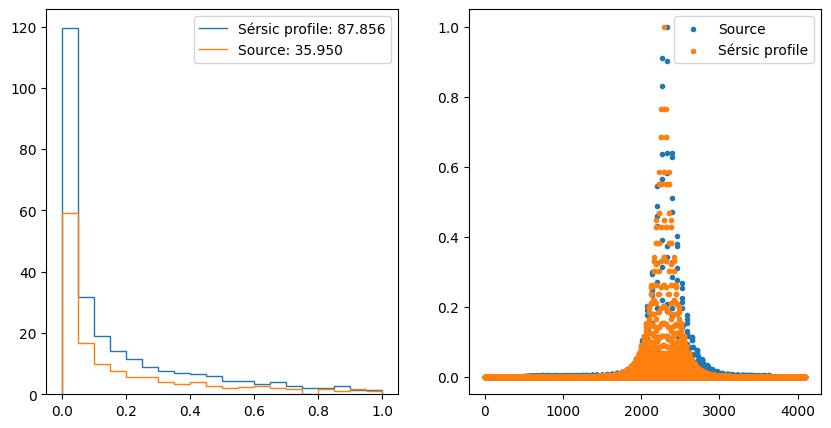

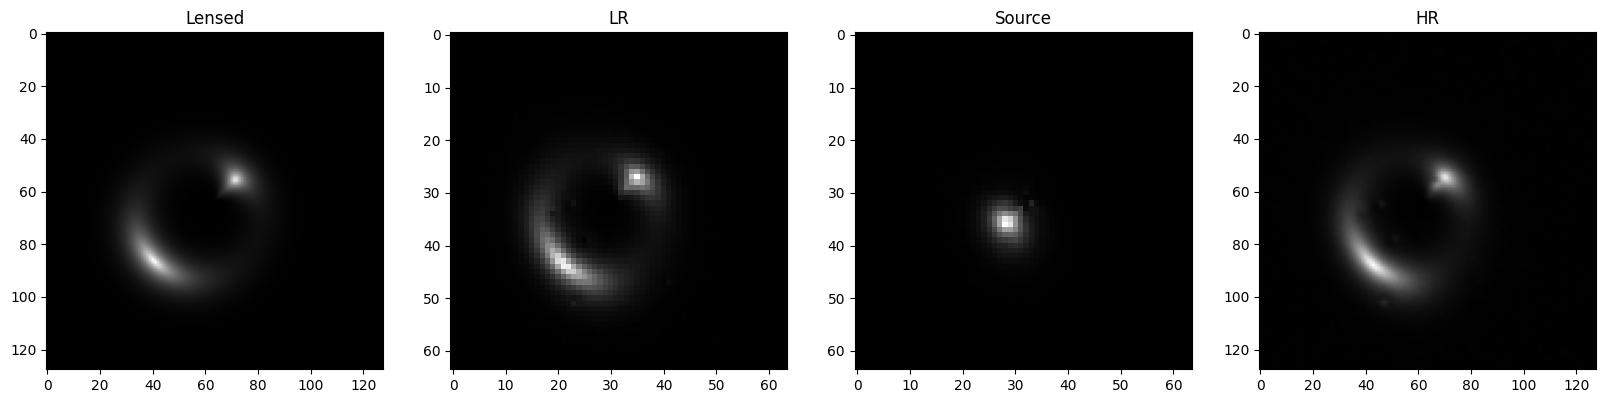

In [8]:
give_image(dataset_cdm, HR_cdm, alpha_model, len(dataset_cdm), plot=True)

In [9]:
def PSNR(mse): 
    """
    Computes the peak-signal to noise ratio

    :param mse: MSE to calculate from
    :return: PSNR value
    """ 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr

from skimage.metrics import structural_similarity
history_no_sub = {'loss':[],'SSIM':[], 'PSNR':[], 'vdl':[]}
history_axion = {'loss':[],'SSIM':[], 'PSNR':[], 'vdl':[]}
history_cdm = {'loss':[],'SSIM':[], 'PSNR':[], 'vdl':[]}

In [10]:
alpha_model.eval()
for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating CDM sub-structure images"):
    image, _, __, HR = give_image(dataset_cdm, HR_cdm, alpha_model, len(dataset_no_sub), i, False, history_cdm)
    if convolve_gaussian:
        image = torch.tensor(gaussian_filter(image.detach().cpu().numpy(), sigma=sigma_pixels)).to(device)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_cdm['loss'].append(float(loss))
    image, HR = image.cpu().numpy(), HR.cpu().numpy()
    history_cdm['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_cdm['PSNR'].append(PSNR(float(loss)))

for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating no sub-structure images"):
    image, _, __, HR = give_image(dataset_no_sub, HR_no_sub, alpha_model, len(dataset_no_sub), i, False, history_no_sub)
    if convolve_gaussian:
        image = torch.tensor(gaussian_filter(image.detach().cpu().numpy(), sigma=sigma_pixels)).to(device)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_no_sub['loss'].append(float(loss))
    image, HR = image.cpu().numpy(), HR.cpu().numpy()
    history_no_sub['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_no_sub['PSNR'].append(PSNR(float(loss)))

for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating axion DM sub-structure images"):
    image, _, __, HR = give_image(dataset_axion, HR_axion, alpha_model, len(dataset_no_sub), i, False, history_axion)
    if convolve_gaussian:
        image = torch.tensor(gaussian_filter(image.detach().cpu().numpy(), sigma=sigma_pixels)).to(device)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_axion['loss'].append(float(loss))
    image, HR = image.cpu().numpy(), HR.cpu().numpy()
    history_axion['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_axion['PSNR'].append(PSNR(float(loss)))

Evaluating axion DM sub-structure images: 100%|██████████| 5000/5000 [00:54<00:00, 91.16it/s]


In [11]:
print(f"no_sub: Evaluation completed with \nMSE: {np.mean(history_no_sub['loss'])} ({np.std(history_no_sub['loss'])})\nSSIM: {np.mean(history_no_sub['SSIM'])} ({np.std(history_no_sub['SSIM'])})\nPSNR:  {np.mean(history_no_sub['PSNR'])} ({np.std(history_no_sub['PSNR'])})")
print(f"axion: Evaluation completed with \nMSE: {np.mean(history_axion['loss'])} ({np.std(history_axion['loss'])})\nSSIM: {np.mean(history_axion['SSIM'])} ({np.std(history_axion['SSIM'])})\nPSNR:  {np.mean(history_axion['PSNR'])} ({np.std(history_axion['PSNR'])})")
print(f"cdm: Evaluation completed with \nMSE: {np.mean(history_cdm['loss'])} ({np.std(history_cdm['loss'])})\nSSIM: {np.mean(history_cdm['SSIM'])} ({np.std(history_cdm['SSIM'])})\nPSNR:  {np.mean(history_cdm['PSNR'])} ({np.std(history_cdm['PSNR'])})")

no_sub: Evaluation completed with 
MSE: 0.00415635786789811 (0.004110044137211117)
SSIM: 0.7862861109264503 (0.05398823313562423)
PSNR:  25.51907961509441 (3.6996546899108056)
axion: Evaluation completed with 
MSE: 0.0038837411422972218 (0.004362844868845998)
SSIM: 0.790298943018548 (0.06040814779077456)
PSNR:  26.53671842301663 (4.6129909061678)
cdm: Evaluation completed with 
MSE: 0.0038831339243204227 (0.00406690968167054)
SSIM: 0.7864422194127078 (0.054080989352676634)
PSNR:  25.986411150092614 (3.8974661557705446)


In [12]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Sub-structure","MSE","SSIM","PSNR","VDL"]
table.add_row(["No_substructure","%0.6f"%np.mean(history_no_sub['loss']),"%0.3f"%np.mean(history_no_sub['SSIM']),"%0.3f"%np.mean(history_no_sub['PSNR']), "%0.3f (%0.3f)"%(np.mean(history_no_sub['vdl']),np.std(history_no_sub['vdl']))])
table.add_row(["Axion (vortex)","%0.6f"%np.mean(history_axion['loss']),"%0.3f"%np.mean(history_axion['SSIM']),"%0.3f"%np.mean(history_axion['PSNR']), "%0.3f (%0.3f)"%(np.mean(history_axion['vdl']),np.std(history_axion['vdl']))])
table.add_row(["CDM (sub-halos)","%0.6f"%np.mean(history_cdm['loss']),"%0.3f"%np.mean(history_cdm['SSIM']),"%0.3f"%np.mean(history_cdm['PSNR']), "%0.3f (%0.3f)"%(np.mean(history_cdm['vdl']),np.std(history_cdm['vdl']))])
print(table)

+-----------------+----------+-------+--------+---------------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |
+-----------------+----------+-------+--------+---------------+
| No_substructure | 0.004156 | 0.786 | 25.519 | 0.000 (0.000) |
|  Axion (vortex) | 0.003884 | 0.790 | 26.537 | 0.000 (0.000) |
| CDM (sub-halos) | 0.003883 | 0.786 | 25.986 | 0.000 (0.000) |
+-----------------+----------+-------+--------+---------------+


In [13]:
""" Sparse_data: 
Model 1:
+-----------------+----------+-------+--------+---------------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |
+-----------------+----------+-------+--------+---------------+
| No_substructure | 0.003353 | 0.762 | 25.390 | 0.000 (0.000) |
|  Axion (vortex) | 0.002968 | 0.763 | 25.763 | 0.000 (0.000) |
| CDM (sub-halos) | 0.003188 | 0.755 | 25.519 | 0.000 (0.000) |
+-----------------+----------+-------+--------+---------------+

Model 2:
+-----------------+----------+-------+--------+---------------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |
+-----------------+----------+-------+--------+---------------+
| No_substructure | 0.005071 | 0.211 | 23.459 | 0.001 (0.002) |
|  Axion (vortex) | 0.004829 | 0.214 | 23.814 | 0.001 (0.002) |
| CDM (sub-halos) | 0.005044 | 0.211 | 23.519 | 0.001 (0.002) |
+-----------------+----------+-------+--------+---------------+

Model 3:
+-----------------+----------+-------+--------+---------------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |
+-----------------+----------+-------+--------+---------------+
| No_substructure | 0.004156 | 0.786 | 25.519 | 0.000 (0.000) |
|  Axion (vortex) | 0.003884 | 0.790 | 26.537 | 0.000 (0.000) |
| CDM (sub-halos) | 0.003883 | 0.786 | 25.986 | 0.000 (0.000) |
+-----------------+----------+-------+--------+---------------+
"""

' Sparse_data: \nModel 1:\n+-----------------+----------+-------+--------+---------------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |\n+-----------------+----------+-------+--------+---------------+\n| No_substructure | 0.003353 | 0.762 | 25.390 | 0.000 (0.000) |\n|  Axion (vortex) | 0.002968 | 0.763 | 25.763 | 0.000 (0.000) |\n| CDM (sub-halos) | 0.003188 | 0.755 | 25.519 | 0.000 (0.000) |\n+-----------------+----------+-------+--------+---------------+\n\nModel 2:\n+-----------------+----------+-------+--------+---------------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |\n+-----------------+----------+-------+--------+---------------+\n| No_substructure | 0.005071 | 0.211 | 23.459 | 0.001 (0.002) |\n|  Axion (vortex) | 0.004829 | 0.214 | 23.814 | 0.001 (0.002) |\n| CDM (sub-halos) | 0.005044 | 0.211 | 23.519 | 0.001 (0.002) |\n+-----------------+----------+-------+--------+---------------+\n\nModel 3: (retrain)\n+-----------------+----------